<a href="https://colab.research.google.com/github/heraclex12/FER-ResidualMaskingNetwork/blob/master/Residual_Masking_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.initializers import glorot_uniform
from keras.layers import Input, ZeroPadding2D, Add, GlobalAveragePooling2D, Concatenate, Conv2DTranspose, Multiply
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dropout, Dense, AveragePooling2D, Lambda, Softmax
from keras.models import Sequential, Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.utils.data_utils import get_file
from sklearn.metrics import confusion_matrix, classification_report
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings 
import tensorflow as tf
warnings.filterwarnings('ignore')

In [ ]:
training_set = pd.read_csv("drive/My Drive/fer2013_data/train.csv")
test_set = pd.read_csv("drive/My Drive/fer2013_data/test.csv")
validation_set = pd.read_csv("drive/My Drive/fer2013_data/val.csv")

In [ ]:
training_labels = to_categorical(training_set['emotion'])
test_labels = to_categorical(test_set['emotion'])
validation_labels = to_categorical(validation_set['emotion'])

training_pixels = training_set['pixels'].str.split().tolist()
training_pixels = np.array(training_pixels)
training_pixels = training_pixels.reshape(-1, 48, 48, 1)
training_pixels = training_pixels.astype(np.float32) / 255
training_pixels = np.repeat(training_pixels, 3, -1)        # convert to 3channels


test_pixels = test_set['pixels'].str.split().tolist()
test_pixels = np.array(test_pixels)
test_pixels = test_pixels.reshape(-1, 48, 48, 1)
test_pixels = test_pixels.astype(np.float32) / 255
test_pixels = np.repeat(test_pixels, 3, -1)        # convert to 3channels


validation_pixels = validation_set['pixels'].str.split().tolist()
validation_pixels = np.array(validation_pixels)
validation_pixels = validation_pixels.reshape(-1, 48, 48, 1)
validation_pixels = validation_pixels.astype(np.float32) / 255
validation_pixels = np.repeat(validation_pixels, 3, -1)        # convert to 3channels

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# RESNET34

In [ ]:
def identity_block(X, f, stage, block):
  name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
  conv_name = name_base + 'conv'
  bn_name = name_base + 'bn'
  relu_name = name_base + 'relu'
  sc_name = name_base + 'sc'

  X_shortcut = X

  X = BatchNormalization(axis=3, name=bn_name + '1')(X)
  X = Activation('relu', name=relu_name + '1')(X) 
  X = Conv2D(filters=f, kernel_size=(3, 3), strides=(1, 1), padding='same', bias=False, name=conv_name + '1')(X)

  X = BatchNormalization(axis = 3, name=bn_name + '2')(X)
  X = Activation('relu', name=relu_name + '2')(X) 
  X = Conv2D(filters=f, kernel_size=(3, 3), strides=(1, 1), padding='same', bias=False, name=conv_name + '2')(X)


  X = Add()([X, X_shortcut])
  return X

def conv_block(X, f, stage, block, strides=(2, 2)):
  name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
  conv_name = name_base + 'conv'
  bn_name = name_base + 'bn'
  relu_name = name_base + 'relu'
  sc_name = name_base + 'sc'

  X = BatchNormalization(axis=3, name=bn_name + '1')(X)
  X = Activation('relu', name=relu_name + '1')(X) 

  X_shortcut = Conv2D(filters=f, kernel_size=(1, 1), strides=strides, padding='same', bias=False, name=sc_name)(X)

  X = Conv2D(filters=f, kernel_size=(3, 3), strides=strides, padding='same', bias=False, name=conv_name + '1')(X)

  X = BatchNormalization(axis = 3, name=bn_name + '2')(X)
  X = Activation('relu', name=relu_name + '2')(X) 
  X = Conv2D(filters=f, kernel_size=(3, 3), strides=(1, 1), padding='same', bias=False, name=conv_name + '2')(X)


  X = Add()([X, X_shortcut])
  return X
  
def ResNet(input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=7):

    img_input = Input(shape=input_shape)

    
    bn_axis = 3
    x = Lambda(lambda img : tf.image.resize(img, (224, 224)))(img_input)
    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x = Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      bias=False,
                      kernel_initializer='he_normal',
                      name='conv0')(x)
    x = BatchNormalization(axis=bn_axis, name='bn0')(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pooling0')(x)

    x = conv_block(x, 64, stage=0, block=0, strides=(1, 1))
    x = identity_block(x, 64, stage=0, block=1)
    x = identity_block(x, 64, stage=0, block=2)

    x = conv_block(x, 128, stage=1, block=0)
    x = identity_block(x, 128, stage=1, block=1)
    x = identity_block(x, 128, stage=1, block=2)
    x = identity_block(x, 128, stage=1, block=3)

    x = conv_block(x, 256, stage=2, block=0)
    x = identity_block(x, 256, stage=2, block=1)
    x = identity_block(x, 256, stage=2, block=2)
    x = identity_block(x, 256, stage=2, block=3)
    x = identity_block(x, 256, stage=2, block=4)
    x = identity_block(x, 256, stage=2, block=5)

    x = conv_block(x, 512, stage=3, block=0)
    x = identity_block(x, 512, stage=3, block=1)
    x = identity_block(x, 512, stage=3, block=2)

    x = BatchNormalization(axis=3, name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    # x = AveragePooling2D(pool_size=(2,2), padding='same', name='avg_pool')(x)
    # x = Flatten()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax', name='fc7')(x)

    # Create model.
    model = Model(img_input, x, name='resnet')

    weights_path = get_file(
        'resnet34_imagenet_1000_no_top.h5',
        'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5',
        cache_subdir='models',
        md5_hash='8caaa0ad39d927cb8ba5385bf945d582'
    )
    model.load_weights(weights_path, by_name=True)

    return model

In [ ]:
model = ResNet(input_shape=(48, 48, 3), classes=7)
model.summary()

for layer in model.layers[:-3]:
  layer.trainable = False

lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=3, verbose=1)
checkpointer = ModelCheckpoint("drive/My Drive/fer2013_data/models/residual_masking.h5", monitor='val_accuracy', verbose=1, save_best_only=True)

model.compile(optimizer=SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(aug.flow(training_pixels, training_labels, 48), steps_per_epoch=len(training_pixels) // 48, epochs=15, 
                             validation_data= (validation_pixels, validation_labels),  callbacks=[lr_reducer, checkpointer])



for layer in model.layers[:-3]:
  layer.trainable = True

model.compile(optimizer=SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(aug.flow(training_pixels, training_labels, 48), steps_per_epoch=len(training_pixels) // 48, epochs=50, 
                             validation_data= (validation_pixels, validation_labels),  callbacks=[lr_reducer, checkpointer])


In [ ]:
test_model = ResNet(input_shape=(48, 48, 3), classes=7)
test_model.compile(optimizer=SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
test_model.load_weights("drive/My Drive/fer2013_data/models/residual_masking.h5")
score, acc = test_model.evaluate(test_pixels, test_labels, verbose=0)
print("Accuracy:", acc)
print("Score:", score)

85524480/85521592 [==============================] - 1s 0us/step
Accuracy: 0.692672073841095
Score: 1.638726452350986


# RESIDUAL MASKING NETWORK

In [ ]:
def masking(X, f, stage, block, depth):
  filters = [f, f * 2, f * 4, f * 8, f * 16]
  
  if depth == 1:
    X = conv_block(X, filters[1], stage, block + 1, strides=(1, 1))
    X = conv_block(X, filters[0], stage, block + 2, strides=(1, 1))
  elif depth == 2:
    X1 = conv_block(X, filters[1], stage, block + 1, strides=(1, 1))
    P1 = MaxPooling2D((2, 2))(X1)
    X2 = conv_block(P1, filters[2], stage, block + 2, strides=(1, 1))
  
    X3 = Conv2DTranspose(filters[1], kernel_size=(2, 2), strides=(2, 2))(X2)
    X3 = BatchNormalization(axis=3)(X3)
    X3 = Activation('relu')(X3)
    X3 = Concatenate(axis=-1)([X3, X1])
    X3 = conv_block(X3, filters[1], stage, block + 3, strides=(1, 1))

    X = conv_block(X3, filters[0], stage, block + 4, strides=(1, 1))
  elif depth == 3:
    X1 = conv_block(X, filters[1], stage, block + 1, strides=(1, 1))
    P1 = MaxPooling2D((2, 2))(X1)
    X2 = conv_block(P1, filters[2], stage, block + 2, strides=(1, 1))
    P2 = MaxPooling2D((2, 2))(X2)
    X3 = conv_block(P2, filters[3], stage, block + 3, strides=(1, 1))

    X4 = Conv2DTranspose(filters[2], kernel_size=(2, 2), strides=(2, 2))(X3)
    X4 = BatchNormalization(axis=3)(X4)
    X4 = Activation('relu')(X4)
    X4 = Concatenate(axis=-1)([X4, X2])
    X4 = conv_block(X4, filters[2], stage, block + 4, strides=(1, 1))

    X5 = Conv2DTranspose(filters[1], kernel_size=(2, 2), strides=(2, 2))(X4)
    X5 = BatchNormalization(axis=3)(X5)
    X5 = Activation('relu')(X5)
    X5 = Concatenate(axis=-1)([X5, X1])
    X5 = conv_block(X5, filters[1], stage, block + 5, strides=(1, 1))

    X = conv_block(X5, filters[0], stage, block + 6, strides=(1, 1))
  elif depth == 4:
    X1 = conv_block(X, filters[1], stage, block + 1, strides=(1, 1))
    P1 = MaxPooling2D((2, 2))(X1)
    X2 = conv_block(P1, filters[2], stage, block + 2, strides=(1, 1))
    P2 = MaxPooling2D((2, 2))(X2)
    X3 = conv_block(P2, filters[3], stage, block + 3, strides=(1, 1))
    P3 = MaxPooling2D((2, 2))(X3)
    X4 = conv_block(P3, filters[4], stage, block + 4, strides=(1, 1))

    X5 = Conv2DTranspose(filters[3], kernel_size=(2, 2), strides=(2, 2), padding='same')(X4)
    X5 = BatchNormalization(axis=3)(X5)
    X5 = Activation('relu')(X5)
    X5 = Concatenate(axis=-1)([X5, X3])
    X5 = conv_block(X5, filters[3], stage, block + 5, strides=(1, 1))

    X6 = Conv2DTranspose(filters[2], kernel_size=(2, 2), strides=(2, 2), padding='same')(X5)
    X6 = BatchNormalization(axis=3)(X6)
    X6 = Activation('relu')(X6)
    X6 = Concatenate(axis=-1)([X6, X2])
    X6 = conv_block(X6, filters[2], stage, block + 6, strides=(1, 1))

    X7 = Conv2DTranspose(filters[1], kernel_size=(2, 2), strides=(2, 2), padding='same')(X6)
    X7 = BatchNormalization(axis=3)(X7)
    X7 = Activation('relu')(X7)
    X7 = Concatenate(axis=-1)([X7, X1])
    X7 = conv_block(X7, filters[1], stage, block + 7, strides=(1, 1))

    X = conv_block(X7, filters[0], stage, block + 8, strides=(1, 1))
  
  X = Softmax(axis=-1)(X)
  return X

In [ ]:
def identity_block(X, f, stage, block):
  name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
  conv_name = name_base + 'conv'
  bn_name = name_base + 'bn'
  relu_name = name_base + 'relu'
  sc_name = name_base + 'sc'

  X_shortcut = X

  X = BatchNormalization(axis=3, name=bn_name + '1')(X)
  X = Activation('relu', name=relu_name + '1')(X) 
  X = Conv2D(filters=f, kernel_size=(3, 3), strides=(1, 1), padding='same', bias=False, name=conv_name + '1')(X)

  X = BatchNormalization(axis = 3, name=bn_name + '2')(X)
  X = Activation('relu', name=relu_name + '2')(X) 
  X = Conv2D(filters=f, kernel_size=(3, 3), strides=(1, 1), padding='same', bias=False, name=conv_name + '2')(X)


  X = Add()([X, X_shortcut])
  return X

def conv_block(X, f, stage, block, strides=(2, 2)):
  name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
  conv_name = name_base + 'conv'
  bn_name = name_base + 'bn'
  relu_name = name_base + 'relu'
  sc_name = name_base + 'sc'

  X = BatchNormalization(axis=3, name=bn_name + '1')(X)
  X = Activation('relu', name=relu_name + '1')(X) 

  X_shortcut = Conv2D(filters=f, kernel_size=(1, 1), strides=strides, padding='same', bias=False, name=sc_name)(X)

  X = Conv2D(filters=f, kernel_size=(3, 3), strides=strides, padding='same', bias=False, name=conv_name + '1')(X)

  X = BatchNormalization(axis = 3, name=bn_name + '2')(X)
  X = Activation('relu', name=relu_name + '2')(X) 
  X = Conv2D(filters=f, kernel_size=(3, 3), strides=(1, 1), padding='same', bias=False, name=conv_name + '2')(X)


  X = Add()([X, X_shortcut])
  return X

In [ ]:
def ResMaskingNet(input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=7):

    img_input = Input(shape=input_shape)

    
    bn_axis = 3
    x = Lambda(lambda img : tf.image.resize(img, (224, 224)))(img_input)
    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x = Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      bias=False,
                      kernel_initializer='he_normal',
                      name='conv0')(x)
    x = BatchNormalization(axis=bn_axis, name='bn0')(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pooling0')(x)

    x = conv_block(x, 64, stage=0, block=0, strides=(1, 1))
    x = identity_block(x, 64, stage=0, block=1)
    x = identity_block(x, 64, stage=0, block=2)
    M = masking(x, 64, stage=0, block=92, depth=4)
    M = Lambda(lambda m : 1 + m)(M)
    x = Multiply()([x, M])

    x = conv_block(x, 128, stage=1, block=0)
    x = identity_block(x, 128, stage=1, block=1)
    x = identity_block(x, 128, stage=1, block=2)
    x = identity_block(x, 128, stage=1, block=3)
    M = masking(x, 128, stage=1, block=93, depth=3)
    M = Lambda(lambda m : 1 + m)(M)
    x = Multiply()([x, M])

    x = conv_block(x, 256, stage=2, block=0)
    x = identity_block(x, 256, stage=2, block=1)
    x = identity_block(x, 256, stage=2, block=2)
    x = identity_block(x, 256, stage=2, block=3)
    x = identity_block(x, 256, stage=2, block=4)
    x = identity_block(x, 256, stage=2, block=5)
    M = masking(x, 256, stage=2, block=95, depth=2)
    M = Lambda(lambda m : 1 + m)(M)
    x = Multiply()([x, M])

    x = conv_block(x, 512, stage=3, block=0)
    x = identity_block(x, 512, stage=3, block=1)
    x = identity_block(x, 512, stage=3, block=2)
    M = masking(x, 512, stage=3, block=92, depth=1)
    M = Lambda(lambda m : 1 + m)(M)
    x = Multiply()([x, M])

    x = BatchNormalization(axis=3, name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    # x = AveragePooling2D(pool_size=(2,2), padding='same', name='avg_pool')(x)
    # x = Flatten()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(classes, activation='softmax', name='fc7')(x)

    # Create model.
    model = Model(img_input, x, name='resnet')

    weights_path = get_file(
        'resnet34_imagenet_1000_no_top.h5',
        'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5',
        cache_subdir='models',
        md5_hash='8caaa0ad39d927cb8ba5385bf945d582'
    )
    model.load_weights(weights_path, by_name=True)

    return model

In [ ]:
model = ResMaskingNet(input_shape=(48, 48, 3), classes=7)

for layer in model.layers[:-1]:
  layer.trainable = False

lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=3, verbose=1)
checkpointer = ModelCheckpoint("drive/My Drive/fer2013_data/models/residual_masking.h5", monitor='val_accuracy', verbose=1, save_best_only=True)

model.compile(optimizer=SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(aug.flow(training_pixels, training_labels, 48), steps_per_epoch=len(training_pixels) // 48, epochs=15, 
                             validation_data= (validation_pixels, validation_labels),  callbacks=[lr_reducer, checkpointer])



for layer in model.layers[:-1]:
  layer.trainable = True

model.compile(optimizer=SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(aug.flow(training_pixels, training_labels, 48), steps_per_epoch=len(training_pixels) // 48, epochs=70, 
                             validation_data= (validation_pixels, validation_labels),  callbacks=[lr_reducer, checkpointer])


85524480/85521592 [==============================] - 1s 0us/step
Epoch 1/15
598/598 [==============================] - 168s 281ms/step - loss: 1.9926 - accuracy: 0.2721 - val_loss: 1.8059 - val_accuracy: 0.2694

Epoch 00001: val_accuracy improved from -inf to 0.26943, saving model to drive/My Drive/fer2013_data/models/residual_masking.h5
Epoch 2/15
598/598 [==============================] - 156s 261ms/step - loss: 1.9438 - accuracy: 0.2818 - val_loss: 1.8302 - val_accuracy: 0.2597

Epoch 00002: val_accuracy did not improve from 0.26943
Epoch 3/15
598/598 [==============================] - 156s 261ms/step - loss: 1.9529 - accuracy: 0.2812 - val_loss: 1.9978 - val_accuracy: 0.2488

Epoch 00003: val_accuracy did not improve from 0.26943
Epoch 4/15
598/598 [==============================] - 156s 261ms/step - loss: 1.9392 - accuracy: 0.2843 - val_loss: 1.8623 - val_accuracy: 0.2382

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00004: val_accuracy did

In [ ]:
#PREDICT
test_model = ResMaskingNet(input_shape=(48, 48, 3), classes=7)
test_model.compile(optimizer=SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
test_model.load_weights("drive/My Drive/fer2013_data/models/residual_masking_71_best.h5")
score, acc = test_model.evaluate(test_pixels, test_labels, verbose=0)
print("Accuracy:", acc)
print("Score:", score)

85524480/85521592 [==============================] - 1s 0us/step
Accuracy: 0.7113401889801025
Score: 1.987868596440273


### Draw histogram chart

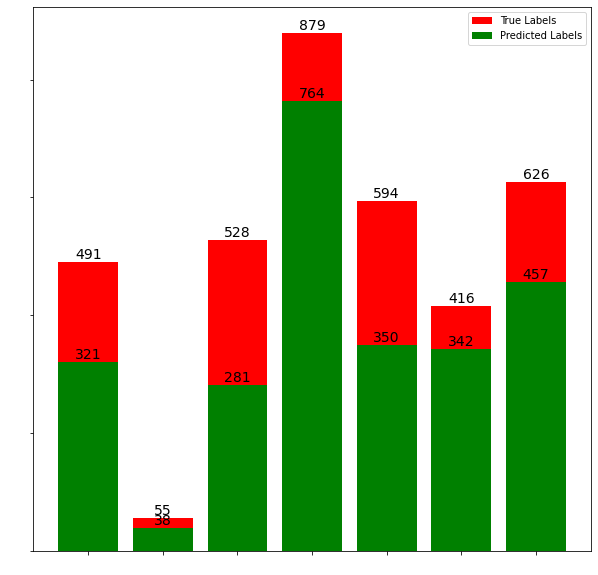

In [ ]:
y_pred = test_model.predict(test_pixels)

cm = confusion_matrix(test_labels, y_pred)
pred_cnt = [cm[i, i] for i in range(len(cm))]
tar_cnt = [sum(cm[i]) for i in range(len(cm))]
plt.figure(figsize=(10, 10))
p1 = plt.bar(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], tar_cnt, color='r')
p2 = plt.bar(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], pred_cnt, color='g')
plt.legend((p1[0], p2[0]), ('True Labels', 'Predicted Labels'))
plt.xticks(color='white')
plt.yticks(color='white')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                '%d' % int(height),
                ha='center', va='bottom', color='black', fontsize=14)

autolabel(p1)
autolabel(p2)

plt.show()

### Draw confusion matrix

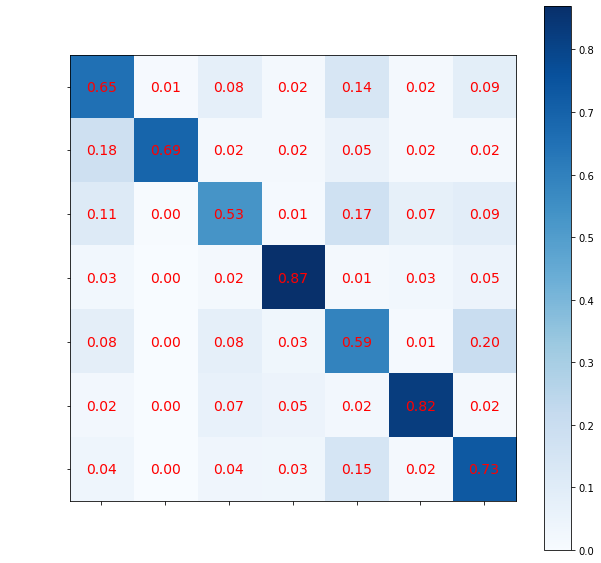

In [ ]:
cm = confusion_matrix(test_labels, y_pred, normalize='true')
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels", color='white')
plt.ylabel("True labels", color='white')
plt.xticks([0, 1, 2, 3, 4, 5, 6],['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], color='white')
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], color='white')
plt.title('Confusion matrix', color='white')
for i in range(len(cm)):
  for j in range(len(cm[i])):
    plt.text(j, i, '%.2f' % cm[i, j], ha='center', va='center', color='red', fontsize=14)
plt.colorbar()
plt.show()